In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, losses_no_conf
from network import exponential_graph, graph, get_alphas
from related_works import colearning, alternating_colearning
from optimization import regularized_local_FW, local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_fixed_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 10000
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

BETA = 10

K, X, Y, X_test, Y_test, max_nb_instances, theta_true, angles, groundtruth_adj_matrix = generate_fixed_moons(D, sample_error_rate=NOISE_R, rnd_state=2017)

# set graph
nodes, adj_matrix, similarities = exponential_graph(X, Y, X_test, Y_test, K, theta_true, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

colors = {
    "Global-Adaboost": "g",
    "Local-Adaboost": "k",
    "Dada-Fixed": "b",
    "Perso-linear-Fixed": "m", 
    "Dada-Learned": "c",    
    "Dada-Random": "r",
}

In [3]:
nodes_copy = deepcopy(nodes)
results["Dada-Fixed"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, 
                                mu=1, monitors=monitors, checkevery=100)

In [5]:
rnd_graph = np.random.random((K, K))
rnd_nodes = graph(X, Y, X_test, Y_test, K, rnd_graph > 0, rnd_graph, max_nb_instances)

nodes_copy = deepcopy(rnd_nodes)
results["Dada-Random"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, 
                                mu=1, monitors=monitors, checkevery=100)

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["Global-Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [5]:
results["Perso-linear-Fixed"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, 
                                similarities, mu=1, max_samples_per_node=max_nb_instances, checkevery=100)

In [6]:
from evaluation import kalo_objective

# graph discovery
gd_pace = 2000

MU, LA = 0.1, 1

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)
results["Dada-Learned"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, 
                    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=20000, monitors=monitors, checkevery=100)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))


In [8]:
# graph discovery
gd_pace = 2000

MU, LA = 0.1, 1

monitors = {
    'test-accuracy': [central_test_accuracy, []],
    'train-accuracy': [central_train_accuracy, []],
}

gd_nodes = deepcopy(nodes)
results["Dada-Learned-$\kappa=10$"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"block_kalo", "pace_gd": gd_pace, 
                    "args":(MU, LA, 10, 1000)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

colors["Dada-Learned-$\kappa=10$"] = "y"

999
999
999
999
0
999


# Accuracy and Convergence

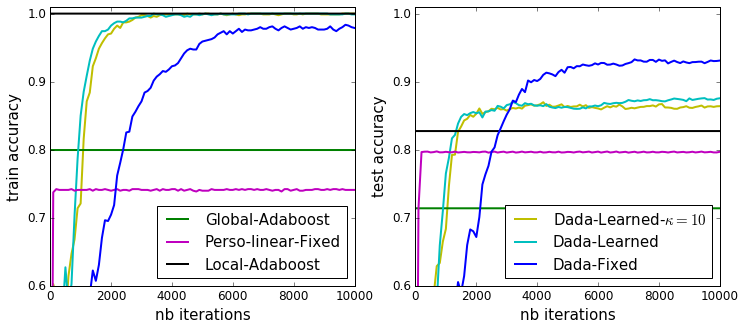

In [9]:
plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('train accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 1.01)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = k
    if k.startswith("Dada"):
        label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 1.01)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = '_nolegend_'
    if k.startswith("Dada"):
        label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("moons-clust-acc-kappa.pdf", bbox_inches="tight")

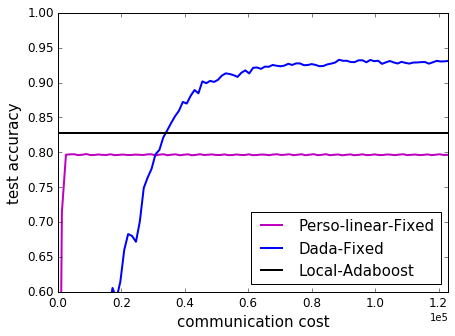

In [18]:
from math import log
    
Z = 32

# test accuracy vs communication
linear_com = 2*D*Z
# regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]
ground_com = np.sum(adj_matrix)/K *(Z + log(n))

x_linear = [linear_com*i for i in range(len(results['Perso-linear-Fixed']))]
# x_dada = [sum(regularized_com[:i]) for i in range(len(results['Dada']))]
x_ground = [ground_com*i for i in range(len(results['Dada-Fixed']))] 

plt.figure(1, figsize=(7, 5))

plt.xlabel('communication cost', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)

# plt.plot(x_kappa, [r['test-accuracy'] for r in results['Dada $\kappa=10$']], label='Dada $\kappa=10$', color=colors['Dada $\kappa=10$'], linewidth=2)
plt.plot(x_linear, [r['test-accuracy'] for r in results['Perso-linear-Fixed']], label='Perso-linear-Fixed', color=colors['Perso-linear-Fixed'], linewidth=2)
plt.plot(x_ground, [r['test-accuracy'] for r in results['Dada-Fixed']], label='Dada-Fixed', color=colors['Dada-Fixed'], linewidth=2)
# plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot([0, min(max(x_ground), max(x_linear))], [results["Local-Adaboost"]["test-accuracy"]]*2, label='Local-Adaboost', color=colors['Local-Adaboost'], linewidth=2)

# plt.xlim(0, min(max(x_dada), max(x_linear), max(x_ground), max(x_kappa)))
plt.xlim(0, min(max(x_ground), max(x_linear)))

plt.legend(loc="lower right", fontsize=15)

plt.ylim(0.6, 1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.savefig("moons-clust-comm.pdf", bbox_inches="tight")

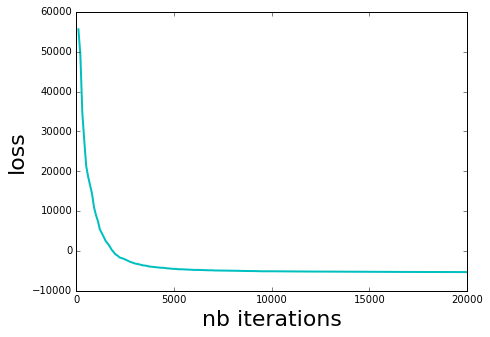

In [9]:
# convergence
plt.figure(1, figsize=(7, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['obj-function'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        pass

# plt.legend(loc='upper right', fontsize=22)

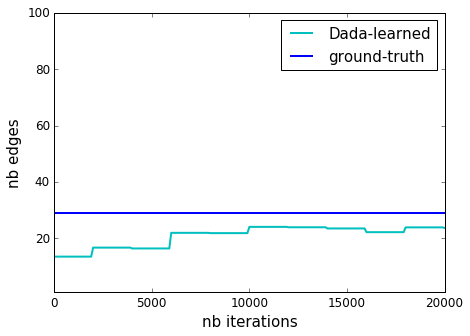

In [28]:
plt.figure(1, figsize=(7, 5))

plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('nb edges', fontsize=15)
plt.xlim(0, 20000)
plt.ylim(1, K)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.plot([i*100 for i in range(len(results["Dada-Learned"]))], [np.mean(r['edges']) for r in results["Dada-Learned"]], color="c", label="Dada-learned", linewidth=2)
plt.plot([0, 20000], [np.mean(np.sum(groundtruth_adj_matrix, axis=0))]*2, label="ground-truth", color="b", linewidth=2)

# print(np.mean())
plt.legend(loc='upper right', fontsize=15)

plt.savefig("moons-clust-edges.pdf", bbox_inches="tight")

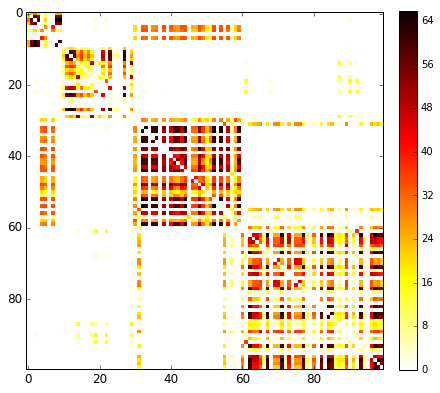

In [21]:
plt.figure(1, figsize=(7, 10))

cax = plt.imshow(results["Dada-Learned"][-1]["similarities"], cmap='hot_r', interpolation='nearest')
plt.colorbar(cax, orientation='vertical', fraction=0.046, pad=0.04)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("moons-clust-heat.pdf", bbox_inches="tight")

## Graph correlations

In [22]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

# print("Correlation with angles")
# print("kalo", spearmanr(matrix_angles, results["Dada"][-1]["similarities"], axis=None))

# print("\nCorrelation with similarities")
# print("kalo", spearmanr(similarities, results["Dada"][-1]["similarities"], axis=None))

In [23]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [24]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results["Dada-Learned"][-1]["adj-matrix"])
kalo_edges, kalo_weights = get_edges_weights(results["Dada-Learned"][-1]["adj-matrix"], results["Dada-Learned"][-1]["similarities"])

groundtruth_graph = nx.from_numpy_matrix(adj_matrix)
gr_edges, gr_weights = get_edges_weights(adj_matrix, similarities)

pos_kalo = nx.spring_layout(kalo_graph)
pos = nx.spring_layout(groundtruth_graph)

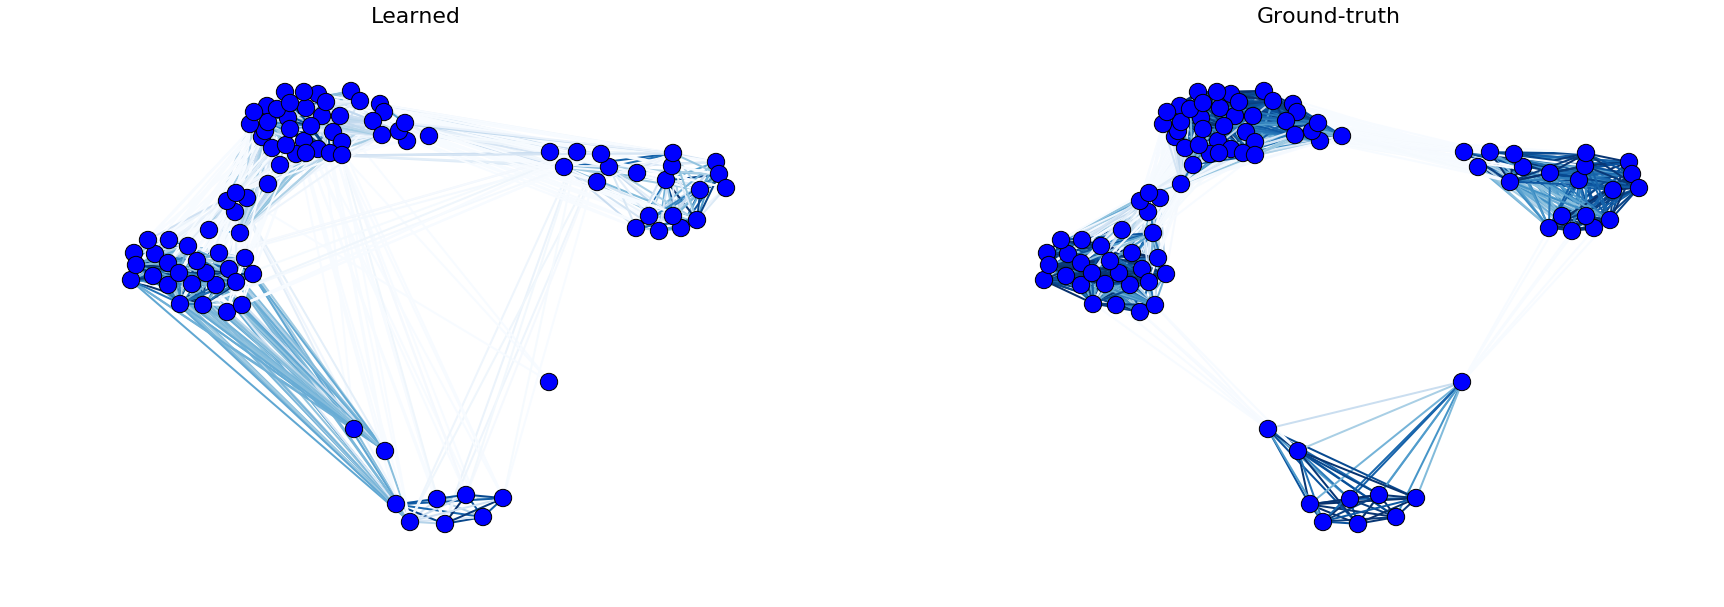

In [25]:
plt.figure(1, figsize=(30, 10))

plt.subplot(121)
plt.title('Learned',fontsize=22)
nx.draw(kalo_graph, pos, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
plt.title('Ground-truth', fontsize=22)
nx.draw(groundtruth_graph, pos, node_color='b', edgelist=gr_edges, edge_color=gr_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.savefig("moons-clust-graphs.pdf", bbox_inches="tight")

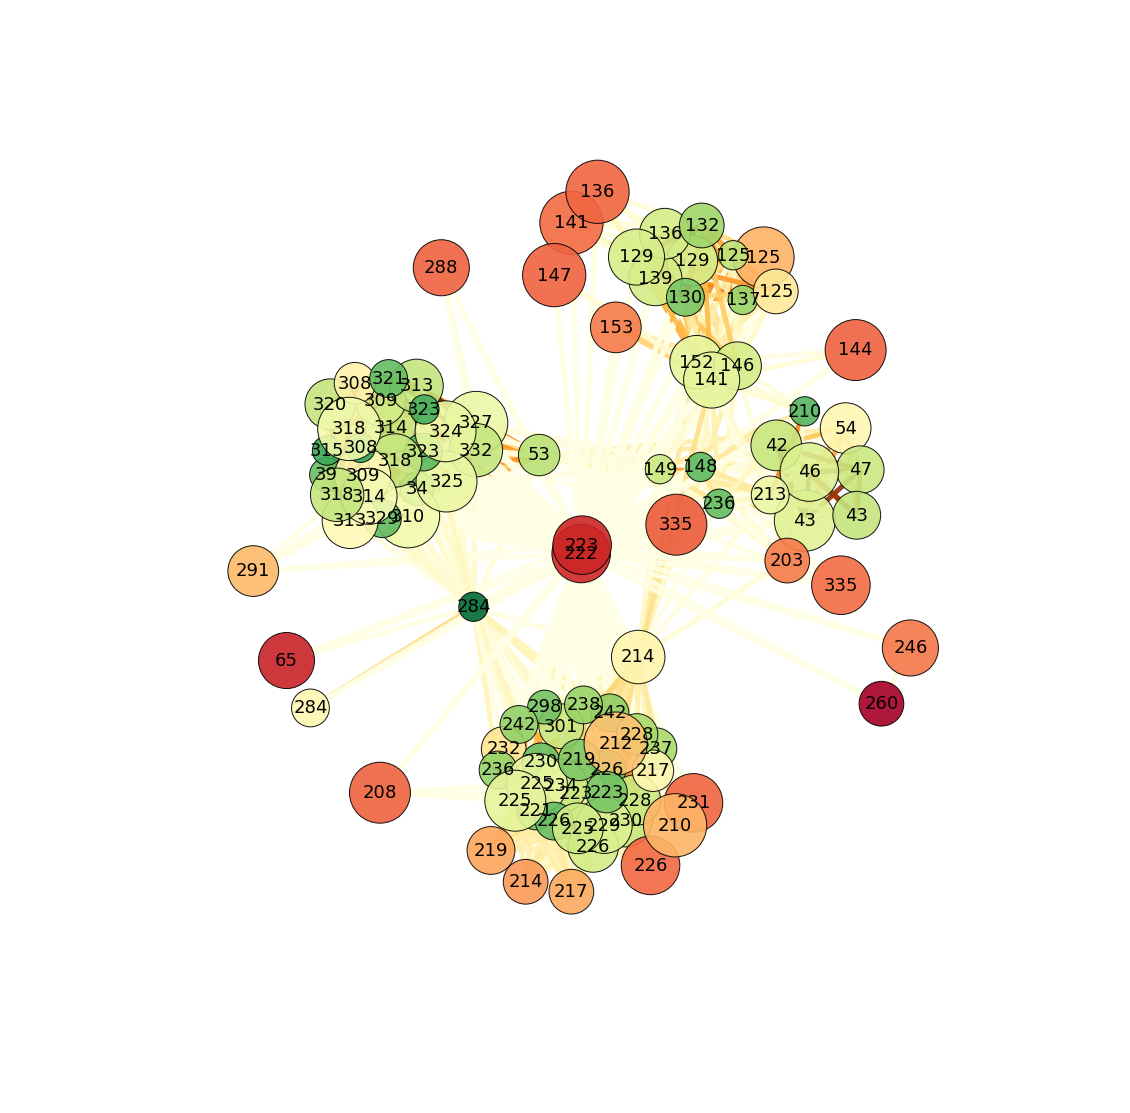

In [26]:
import math

l_list = losses_no_conf(gd_nodes)
plt.figure(1, figsize=(15, 15))

# plt.title('Optimized')
nx.draw(kalo_graph, pos_kalo, node_color=[1-l for l in l_list], node_size=[4000*n.confidence for n in nodes], edgelist=kalo_edges, edge_color=kalo_weights, alpha=0.9, width=5.0, cmap=plt.cm.RdYlGn, edge_cmap=plt.cm.YlOrBr)
nx.draw_networkx_labels(kalo_graph, pos_kalo, labels={i:int(a*180/math.pi) for i,a in enumerate(angles)}, font_size=18, font_color='k', alpha=1.0, ax=None)

plt.savefig("moons-clust-colors.pdf", bbox_inches="tight")

## Accuracy vs sparsity


In [19]:
B_LIST = [j * 10**i for i in range(-3, 3) for j in range(1, 10, 2)]
results_kalo = {}
# results_kalo = {}.fromkeys(B_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
NB_ITER = 10000
MU = 0.1
gd_pace = 500

for b in B_LIST:
    print(b)
    results_kalo[b] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}

    for _ in range(2):
                
        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, b)},
                        beta=BETA, mu=MU, nb_iter=NB_ITER, monitors={})

        results_kalo[b]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[b]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[b]["mean-edges"].append(np.mean(edges(gd_nodes)))

for b in B_LIST:
    results_kalo[b]["train-accuracy"] = np.mean(results_kalo[b]["train-accuracy"])    
    results_kalo[b]["test-accuracy"] = np.mean(results_kalo[b]["test-accuracy"])
    results_kalo[b]["mean-edges"] = np.mean(results_kalo[b]["mean-edges"])


0.001
0.003
0.005
0.007
0.009000000000000001
0.01
0.03
0.05
0.07
0.09
0.1
0.30000000000000004
0.5
0.7000000000000001
0.9
1
3
5
7
9
10
30
50
70
90
100
300
500
700
900


In [26]:
# avg results by lambda
keys = []

for la in B_LIST:
    keys.append(results_kalo[la]["mean-edges"])

keys = set(keys)

# sort results
train = {k: list() for k in keys}
test = {k: list() for k in keys}

for la, value in results_kalo.items():
    train[value["mean-edges"]].append(value["train-accuracy"])
    test[value["mean-edges"]].append(value["test-accuracy"])

sorted_keys = sorted(keys) 

{26.77, 26.379999999999999, 26.689999999999998, 27.050000000000001, 27.82, 27.18, 28.539999999999999, 28.189999999999998, 28.490000000000002, 29.039999999999999, 29.829999999999998, 29.359999999999999, 30.73, 25.780000000000001, 26.98, 26.800000000000001, 28.93, 28.280000000000001, 30.399999999999999, 30.960000000000001, 28.439999999999998, 28.0, 28.039999999999999, 29.869999999999997, 29.130000000000003, 29.379999999999999, 30.940000000000001, 30.359999999999999, 31.149999999999999, 25.43}


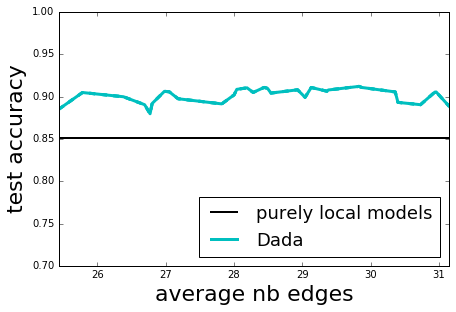

In [28]:
import operator
plt.figure(1, figsize=(7, 10))

# plt.subplot(211)
# plt.xlabel('mean nb edges', fontsize=22)
# plt.ylabel('train accuracy', fontsize=22)


# y = [np.mean(train[k]) for k in sorted_keys]
# std = [np.std(train[k]) for k in sorted_keys]

# plt.plot([0,K], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
# plt.plot(sorted_keys, y, label='Dada', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
# plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")
# # plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)
# plt.xlim(min(sorted_keys), max(sorted_keys))
# plt.ylim(0.7, 1)

# plt.legend(loc='center right', fontsize=18)

plt.subplot(212)
plt.xlabel('average nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

y = [np.mean(test[k]) for k in sorted_keys]
std = [np.std(test[k]) for k in sorted_keys]
# print(y, sorted_keys)
plt.plot([0, K], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2, color='k')
plt.plot(sorted_keys, y, label='Dada', linewidth=3, color='c')
plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.xlim(min(sorted_keys), max(sorted_keys))
plt.ylim(0.7, 1)

plt.legend(loc='lower right', fontsize=18)

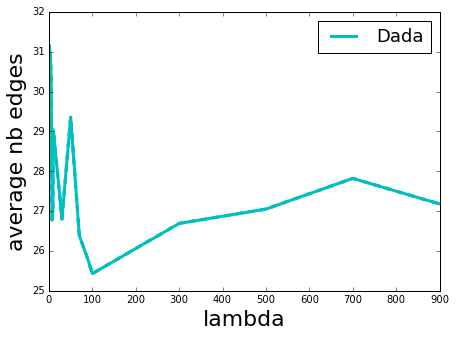

In [29]:
plt.figure(1, figsize=(7, 5))

plt.xlabel('lambda', fontsize=22)
plt.ylabel('average nb edges', fontsize=22)

y = [np.mean(results_kalo[la]["mean-edges"]) for la in LA_LIST]
std = [np.std(results_kalo[la]["mean-edges"]) for la in LA_LIST]
plt.plot(LA_LIST, y, label='Dada', linewidth=3, color="c")
plt.plot(LA_LIST, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(LA_LIST, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.legend(loc='upper right', fontsize=18)

## Study impact of kappa in graph discovery block coordinate descent

In [29]:
from optimization import block_kalo_graph_discovery, kalo_graph_discovery
from utils import kalo_utils

S, triu_ix, map_idx = kalo_utils(K)
MU, LA = 0.1, 1
kappas = [30, 50, 99]

results_dict = {}
# starting from local models
for kappa in kappas:
    results_dict[kappa] = []
    
    for _ in range(5):
        _, obj = block_kalo_graph_discovery(local_nodes, None, S, triu_ix, map_idx, mu=MU, la=LA, kappa=kappa, max_iter=3e5, monitor=True)
        results_dict[kappa].append(obj)

299999
299999
299999
299999
299999
299999
299999
299999
299999
299999
299999
299999
299999
299999
299999


../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))
../src/optimization.py:146: RuntimeWarning: divide by zero encountered in true_divide
  grad = l[rnd_j].dot(S_block) + (mu / 2) * (z[idx_block] - (1. / d_block).dot(S_block) + 2 * la * (mu / 2) * new_w[idx_block])
../src/optimization.py:149: RuntimeWarning: invalid value encountered in less
  new_w[new_w < 0] = 0
../src/optimization.py:47: RuntimeWarning: invalid value encountered in less
  if np.any(d < 0):


In [38]:
kappas = [1, 5, 10]

# starting from local models
for kappa in kappas:
    results_dict[kappa] = []
    
    for _ in range(5):
        _, obj = block_kalo_graph_discovery(local_nodes, None, S, triu_ix, map_idx, mu=MU, la=LA, kappa=kappa, max_iter=1e6, monitor=True)
        results_dict[kappa].append(obj)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))
../src/optimization.py:146: RuntimeWarning: divide by zero encountered in true_divide
  grad = l[rnd_j].dot(S_block) + (mu / 2) * (z[idx_block] - (1. / d_block).dot(S_block) + 2 * la * (mu / 2) * new_w[idx_block])


999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999
999999


../src/optimization.py:47: RuntimeWarning: invalid value encountered in less
  if np.any(d < 0):
../src/optimization.py:149: RuntimeWarning: invalid value encountered in less
  new_w[new_w < 0] = 0


In [49]:
# average 5 iterations
kappas = sorted(results_dict.keys())

objectives = {}
    
for kappa in kappas:
    avgs = [sum(e) / 5 for e in zip(*results_dict[kappa])]
    objectives[kappa] = avgs

In [51]:
# communication
from math import log

cost = min(500, n) / K
Z = 32

comm = {}

for kappa in kappas:
    comm[kappa] = [3 * Z + cost * (Z + log(n)) * i * kappa for i in range(len(objectives[kappa]))]

max_comm = max([comm[kappa][-1] for kappa in kappas])

for kappa in kappas:
    comm[kappa].append(max_comm)
    results_dict[kappa].append(objectives[kappa][-1])
    
full_gd_comm = 99 * cost * (Z + log(n)) + 99 * K * (K - 1) * Z / 2
print(full_gd_comm)
min_obj = objectives[99][1:]


15688985.066838577


In [ ]:
# convergence
plt.figure(1, figsize=(12, 5))

plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('obj function', fontsize=15)

cmap = plt.get_cmap("viridis")

for kappa in kappas:

    plt.plot([i*K for i in range(len(objectives[kappa]))], objectives[kappa], color=cmap(log(kappa) / log(99)), label="kappa = {}".format(kappa), linewidth=2)

plt.legend(loc='upper right', fontsize=12)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlim(0, 1e6)

plt.subplot(122)
plt.xlabel('communication', fontsize=15)
plt.ylabel('obj function', fontsize=15)

for kappa in kappas:
    print(len(comm[kappa]), len(objectives[kappa]))
#     plt.plot(comm[kappa], objectives[kappa], color=cmap(log(kappa) / log(99)), label="kappa = {}".format(kappa), linewidth=2)

plt.plot([full_gd_comm], [min_obj], color="o", label="centralized", linewidth=2)
    
plt.legend(loc='upper right', fontsize=12)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlim(0, 8e6)
plt.savefig("kappas.pdf")